# Import packages

The following methods describe the functions used to produce results with Stone methodology applied to a metacommunity matrix. Each chapter of the thesis will have its own modified version of this code. 

In [1]:
# import packages
import numpy as np
import random 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.integrate import odeint


## Function to vizualize matrix

This function prodives an interactive way to vizualize matrices and the numbers in each row and column. The colorscale might need to be modified depending the range of numbers in the matrix. Specially when there are big differences between minimum numbers and the maximum numbers in $$A_{ij}$$

In [2]:
def plot_matrix(matrix, title="Matrix with Regular Color Scale", use_meta=False):
    """
    Normalize each row of a given matrix and plot a heatmap with a color scale.
    If 'meta' is present in the title, a custom red-to-green color scale is used; 
    otherwise, a regular color scale is used.
    
    Args:
        matrix (numpy.ndarray): Input 2D matrix.
        title (str): Title of the heatmap (used to decide the color scale).
        use_meta (bool): Flag to apply the custom color scale when True, 
                         or use a regular color scale otherwise.
    """
    # Normalize the matrix
    norm_conf = []
    for row in matrix:
        row_sum = sum(row)
        normalized_row = [float(val) / float(row_sum) if row_sum != 0 else 0 for val in row]
        norm_conf.append(normalized_row)
    normalized_matrix = np.array(norm_conf)
    
    # Define custom color scale (red-to-green)
    custom_colorscale = [
        [0, 'darkred'],   # Dark red for negative values
        [0.4999, 'red'],  # Red for negative values
        [0.5, 'white'],   # White for zero values
        [0.511111111, 'blue'],  # Green for positive values
        [1, 'darkblue']  # Dark green for positive values
    ]
    
    # Define regular color scale (default)
    regular_colorscale = 'Viridis'  # You can use any built-in color scale, e.g., 'Viridis', 'Cividis', etc.
    
    # Select color scale based on the flag or title
    colorscale = custom_colorscale if use_meta or 'meta' in title.lower() else regular_colorscale
    
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=matrix,  # Use the original matrix
        x=np.arange(1, matrix.shape[1] + 1),
        y=np.arange(1, matrix.shape[0] + 1),  # Reverse the y-axis labels
        colorscale=colorscale,
        zmid=0,  # Set the midpoint of the color scale to zero
    ))
    
    # Update layout for better visualization
    fig.update_layout(
        yaxis=dict(autorange='reversed'),
        title=title,
        xaxis_title='Column',
        yaxis_title='Row',
    )
    
    # Show the plot
    fig.show()
    
    return #normalized_matrix  # Return the normalized matrix

## Function to sample local communities

### Parameters

S= Number of Species

C=Connectivity

$\sigma$= Standard deviation of interaction strength 

Pm= proportion of mutualistic interaction (+/+)

Pc=proportion of competitive interaction (-/-)

Pe= proportion of exploitative interaction (+/-)

We will create matrix **A**, with dimensions *S* * *S*. The matrix **A** will contain all the interactions between species. The effect of species _i_ on species _j_ is will be on the off diagonal. The diagonal of matrix __A__ will be set to -s. The matrix __A__ elements will be the following:

$$a_{ij}= N(0,\sigma)$$
$$a_{ii}=-s$$

Refrences

Coyte, K. Z., Schluter, J., & Foster, K. R. (2015).Science, 350(6261), 663–666. http://doi.org/10.1126/science.aad2602

May, R. M. (1972). Will a large complex system be stable? Nature, 238(5364), 413–414.

In [3]:
def local_matrix_A (matrix_para):
    
    #pull the values from the list matrix_para
    
    S=matrix_para['S']
    C = matrix_para['C']
    sigma = matrix_para['sigma']
    Pm = matrix_para['Pm']
    Pc = matrix_para['Pc']
    Pe= matrix_para['Pe']
    s = matrix_para['s']
    
    # Ensure that the sum of Pm, Pe, and Pc is equal to 1
    if not np.isclose(Pm + Pe + Pc, 1.0):
        raise ValueError("The sum of Pm, Pe, and Pc must be equal to 1.")
    
    A= np.zeros((S,S))
    
    np.fill_diagonal (A,-s)
    
    #loop to assign values to a_ij and a_ii
    
    for i in range(1,S):
        for j in range(i):
            if np.random.rand()<= C:
                
                #Assign the random variable
                p = np.random.rand()
                a = sigma*abs(np.random.normal(0,1))
                b = sigma*abs(np.random.normal(0,1))
                
                if p > 1-Pm: #assign mutualism
                    A[i,j]= a
                    A[j,i]= b
                    
                elif p<= Pc: #assign competition
                    A[i,j]= -a
                    A[j,i]= -b
                    
                elif Pc<p<=1-Pm: #assign exploitative
                    if np.random.rand()<= 0.5:
                        A[i,j]= a
                        A[j,i]=-b
                    else:
                        A[i,j]= -a
                        A[j,i]= b
    return A
            

In [4]:
#parameters
S=10
C=0.5
sigma= 0.5
Pc=0
Pm=1
Pe=0
s= 1

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}
matrix_para

A=local_matrix_A(matrix_para)
plot_matrix(A)

## Function to sample Local communities into a metacommunity

This function will call the function __local matrix A__ to corresponding to the number of local communities within the metacommunity. The parameter _L_, represents the number of local communities in the system. This code also has built in modifications, so we can explore the stability of universal matrices.

L= number of local communities in the metacommunity


B= Base matrix used to sample other communities if delta is present. This base matrix will be multiply by __V__ matrix, with entries $V_{ij}=U(1-\delta, 1 + \delta)$

$\delta$= measure of universality between the local communities in the metacommunity. If delta is not present, each of the local communities in the metacommunity will be independenly sampled. The delta value will not be greater than 1 due to possible modification to the signs of the base matrix.



In [5]:
# This version only works in single communities
def collection_local_matrices(L, matrix_para):
    
    S = matrix_para['S']
    C = matrix_para['C']
    sigma = matrix_para['sigma']
    Pm = matrix_para['Pm']
    Pc = matrix_para['Pc']
    Pe=matrix_para['Pe']
    s = matrix_para['s']
    
    A = np.empty((S, S, L))
    
    if matrix_para.get('delta') is None:
        for i in range(L):
            A[:, :, i] = local_matrix_A(matrix_para)
    else:
        delta = matrix_para['delta']
        B = local_matrix_A(matrix_para)

        for i in range(L):
            U = np.random.uniform(1 - delta, 1 + delta, (S, S))
            thisA = U * B
            np.fill_diagonal(thisA, -s)
            A[:, :, i] = thisA

    return A
L=2
A=collection_local_matrices(L,matrix_para)

## Function to Arrange values of A into a metacommunity matrix __J__

In [6]:
import numpy as np  # Ensure you have numpy imported

def subcommunity_mask(a, b, S, M):
    """
    Return a mask of the metacommunity matrix
    corresponding to interactions between taxa
    in subcommunities a and b.
    """
    rows = slice((a - 1) * S, a * S)
    cols = slice((b - 1) * S, b * S)
    
    mask = np.zeros((S * M, S * M), dtype=bool)
    mask[rows, cols] = True  # This line is correct as it sets the specified block to True
    
    return mask

def meta_A(L, S, matrix_para):
    """
    This is representative of the A matrix found in the jacobian J
    """
    AA = collection_local_matrices(L, matrix_para)
    
    # Assemble the metacommunity interaction matrix A
    A = np.zeros((S * L, S * L))
    
    # Place interaction matrices along the block diagonal
    for i in range(1, L + 1):
        row_start = (i - 1) * S
        row_end = i * S
        col_start = (i - 1) * S
        col_end = i * S
        
        A[row_start:row_end, col_start:col_end] = AA[:, :, i - 1]
    
    return A

## Function to generate matrix __G__ containing the dispersal of the local communities

In [7]:
import numpy as np

def get_mij(L, S, m):
    """
    Assemble metacommunity immigration matrix (off diagonal) 
    """
    m_ij = np.zeros((S * L, S * L))
    
    row_taxa = np.tile(np.arange(S), (L * S, 1))
    col_taxa = row_taxa.T
    
    x = np.repeat(np.arange(L), S)
    row_subcom = np.tile(x, (L * S, 1))
    col_subcom = row_subcom.T
    
    for i in range(S * L):
        for j in range(S * L):
            is_different_subcom = row_subcom[i, j] != col_subcom[i, j]
            is_same_taxa = row_taxa[i % S, j % S] == col_taxa[i % S, j % S]
            is_disperal = is_different_subcom and is_same_taxa
            
            if is_disperal:
                m_ij[i, j] = m / (L - 1)
    
    return m_ij

# Example usage
L=3
m=4
S=4
m_ij=get_mij(L,S,m)
plot_matrix(m_ij)

## Function to Calculate the $N_i^*$ in order to impose feasibility

All the $N_i^*$ will be arranged in a diagonal matrix __D__. For our perspective to in metacommunity matrix, we need to complete the construction of the metacommunity in order tocalculate its $N_i^*$

In [8]:
def f(N, m, m_ij):
    """
    Calculate the function f. This function is our approximation as migration increases
    """
    return -m + (1 / N) * (m_ij @ N)

def find_feasible_equilibrium(A, r, m, m_ij):
    """
    Find feasible equilibrium N^*.
    """
    Ainv = np.linalg.inv(A)
    Nstar_nomigration = -Ainv @ r
    Approximation = f(Nstar_nomigration, m, m_ij)
    
    Nhatstar = -Ainv @ (Approximation + r)
    
    return Nhatstar

#Example of usage
L=3
S=2
m=1
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)

Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
Nhatstar

array([1.20443583, 0.94938882, 1.51776948, 1.18927142, 1.51776948,
       1.18927142])

In [9]:
# Define the GLV system for a metacommmunity
def glv_system(t, x, r, a, m, m_ij):
    """
    Generalized Lotka-Volterra system.
    
    Parameters:
    - t: Time
    - x: Array of population densities 
    - r: Intrinsic growth rates (array)
    - a: Interaction matrix (2D array, n x n)
    - m: Emigration rates
    - m_ij: immigration rates 
    
    Returns:
    - dx/dt: Time derivative of x
    """
    dxdt = x * (r + np.dot(a, x)) - m * x + np.dot(m_ij, x)
    return dxdt

In [10]:
# Define example parameters
L = 2
S = 100
C = 0.7
sigma = 0.02
Pc = 0
Pm = 1
Pe = 0
s = 1

m = 0
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)


# Get Nhatstar for these parameters
Nhatstar = find_feasible_equilibrium(A, r, m, m_ij)

# Initial conditions
x0 = Nhatstar

# Test GLV function
#out = glv_system(0, x0, r, A, m, m_ij)

Nhatstar

array([-10.45601008, -10.48798379,  -9.57812266, -11.09466095,
       -10.51855288,  -8.99015711, -10.40619897,  -7.81064741,
        -7.10143784,  -8.87866476, -10.71870601, -10.42612725,
       -11.42594669,  -9.34955747, -10.45911112,  -9.92067576,
       -10.38884084,  -8.66007766, -11.20519109, -10.26770209,
        -9.0576459 , -11.38860931,  -9.90159022,  -9.15963903,
        -9.38456273,  -9.65144592, -10.47077273,  -8.47695747,
        -7.80764988, -11.40146091,  -9.18877619,  -8.6677078 ,
        -8.53925116, -10.36814696,  -8.6893012 , -11.45107392,
        -7.89725823,  -8.00786666,  -9.57215197,  -9.49343151,
        -6.55190801, -10.04073674, -10.39505686,  -7.91683616,
        -8.79540877,  -9.14002602,  -9.04320588,  -9.31304622,
        -9.31624325,  -8.20728571,  -7.47705076, -10.37742532,
       -10.0873169 ,  -6.50667204,  -9.56882182,  -9.3797918 ,
        -8.67634439, -10.9184794 ,  -9.30552383, -11.06292232,
       -10.65489093,  -8.73367316,  -9.13776255,  -9.71

In [11]:
# function for replacing negative values with 1 in Nhatstar

def replace_negative_values_with_ones(Nhatstar):
    """
    Replace negative values in Nhatstar with 1.
    """
    Nhatstar[Nhatstar <0] = 1
    return Nhatstar

# Example usage
Nhatstar = replace_negative_values_with_ones(Nhatstar)
Nhatstar

# Initial conditions
x0 = Nhatstar
x0


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Final state values at tmax:
Variable 1: 91.8040
Variable 2: 92.0848
Variable 3: 84.0962
Variable 4: 97.4114
Variable 5: 92.3532
Variable 6: 78.9338
Variable 7: 91.3667
Variable 8: 68.5777
Variable 9: 62.3508
Variable 10: 77.9549
Variable 11: 94.1105
Variable 12: 91.5417
Variable 13: 100.3201
Variable 14: 82.0894
Variable 15: 91.8313
Variable 16: 87.1038
Variable 17: 91.2143
Variable 18: 76.0357
Variable 19: 98.3819
Variable 20: 90.1507
Variable 21: 79.5264
Variable 22: 99.9923
Variable 23: 86.9362
Variable 24: 80.4219
Variable 25: 82.3967
Variable 26: 84.7399
Variable 27: 91.9337
Variable 28: 74.4279
Variable 29: 68.5514
Variable 30: 100.1051
Variable 31: 80.6777
Variable 32: 76.1027
Variable 33: 74.9748
Variable 34: 91.0326
Variable 35: 76.2923
Variable 36: 100.5407
Variable 37: 69.3381
Variable 38: 70.3093
Variable 39: 84.0437
Variable 40: 83.3526
Variable 41: 57.5259
Variable 42: 88.1579
Variable 43: 91.2689
Variable 44: 69.5100
Variable 45: 77.2239
Variable 46: 80.2497
Variable 47:

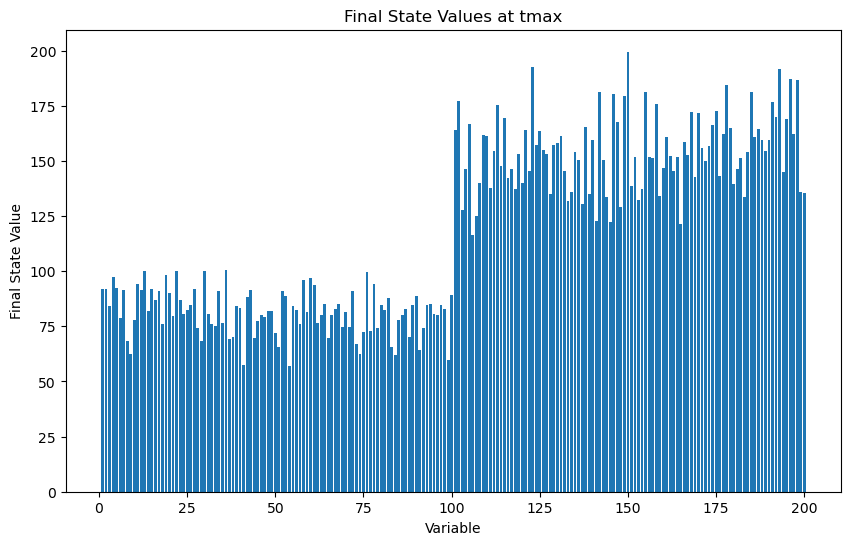

In [22]:
# Numerically integrate the GLV system to find equilibria

from scipy.integrate import solve_ivp

def simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10, 
                        full_output=False):
    """
    Simulates the generalized Lotka-Volterra (GLV) system and returns the final state variables at tmax.

    Parameters:
    glv_system (function): The GLV system function to integrate.
    x0 (array-like): Initial conditions for the state variables.
    r (array-like): Growth rates.
    A (array-like): Interaction matrix.
    m (array-like): Mortality rates.
    m_ij (array-like): Additional interaction parameters.
    tmax (float): Time by which equilibrium is assumed to be reached (default is 10).

    Returns:
    np.ndarray: Final values of the state variables at tmax.
    """
    t_span = (0, tmax)  # Time range for the simulation
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # Evaluation points
    
    # Solve the system
    sol = solve_ivp(
        glv_system, t_span, x0, args=(r, A, m, m_ij), t_eval=t_eval, method='RK45'
    )
    
    # Return the final state variables at tmax
    if full_output:
        return sol
    else:
        return sol.y[:, -1]


Nstar = simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10)
print("Final state values at tmax:")
for i, value in enumerate(Nstar, start=1):
    print(f"Variable {i}: {value:.4f}")

# Plotting Nstar as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(Nstar) + 1), Nstar)
plt.xlabel('Variable')
plt.ylabel('Final State Value')
plt.title('Final State Values at tmax')
plt.show()

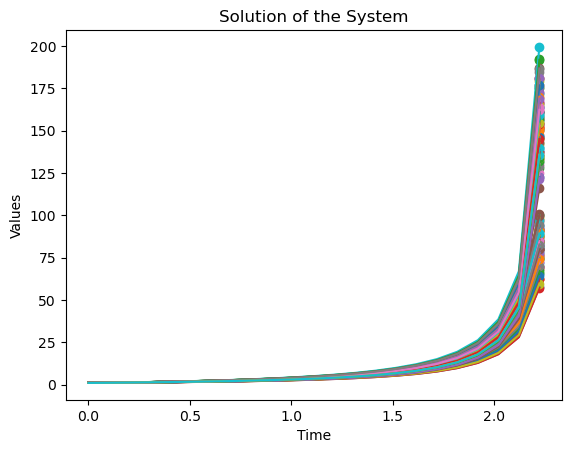

In [23]:
# Plot output
sol = simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10, full_output=True)
Nstar = simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10)
for i in range(sol.y.shape[0]):  # Loop over each variable
    plt.plot(sol.t, sol.y[i], label=f"Variable {i+1}")
    
for i, Nstari in enumerate(Nstar):
    plt.scatter(sol.t[-1], Nstari, label=f"Final Value (Variable {i+1})", marker='o')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System')
#plt.legend()
plt.show()

In [19]:
print(sol.status)
print(sol.message)

-1
Required step size is less than spacing between numbers.


Steady state values:
Variable 1: 1.2813
Variable 2: -0.0000
Variable 3: 0.0000
Variable 4: 0.0000
Variable 5: -0.0000
Variable 6: -0.0000
Variable 7: 0.0000
Variable 8: -0.0000
Variable 9: 1.2553
Variable 10: -0.0000
Variable 11: -0.0000
Variable 12: 1.3421
Variable 13: 0.0000
Variable 14: 1.2098
Variable 15: 0.0000
Variable 16: -0.0000
Variable 17: 1.2662
Variable 18: 0.0000
Variable 19: -0.0000
Variable 20: -0.0000
Variable 21: 0.0000
Variable 22: -0.0000
Variable 23: -0.0000
Variable 24: 1.3476
Variable 25: 0.0000
Variable 26: 0.0000
Variable 27: 0.0000
Variable 28: 0.0000
Variable 29: 1.3472
Variable 30: 0.0000
Variable 31: -0.0000
Variable 32: 0.0000
Variable 33: 0.0000
Variable 34: -0.0000
Variable 35: 0.0000
Variable 36: 0.0000
Variable 37: 0.0000
Variable 38: 0.0000
Variable 39: 1.3168
Variable 40: 0.0000
Variable 41: 1.3346
Variable 42: 1.3334
Variable 43: -0.0000
Variable 44: 1.3359
Variable 45: 0.0000
Variable 46: -0.0000
Variable 47: 1.3171
Variable 48: -0.0000
Variable 49:

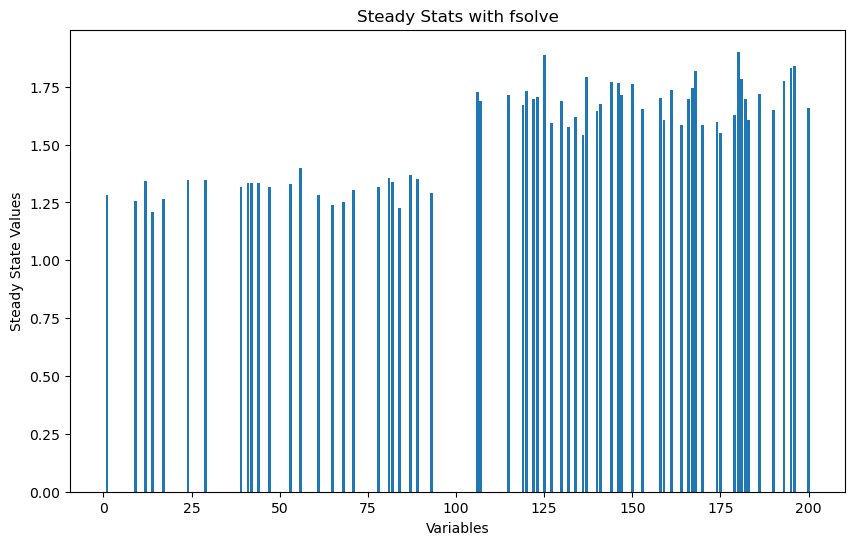

In [50]:
# Simulate steady state of GLV through fsolve(by solving for the roots)
from scipy.optimize import fsolve

def glv_system1(x, r, A, m, m_ij):
    dxdt = x * (r + np.dot(A, x)) - m * x + np.dot(m_ij, x)
    return dxdt


def find_steady_state(glv_system1, x0, r, A, m, m_ij):
    """
    Finds the steady state of the generalized Lotka-Volterra (GLV) system.

    Parameters:
    glv_system (function): The GLV system function.
    x0 (array-like): Initial guess for the state variables.
    r (array-like): Growth rates.
    A (array-like): Interaction matrix.
    m (array-like): Mortality rates.
    m_ij (array-like): Additional interaction parameters.

    Returns:
    np.ndarray: Steady state values of the state variables.
    """
    steady_state = fsolve(glv_system1, x0, args=(r, A, m, m_ij))
    return steady_state

# Example usage
L = 2
S = 100
C = 0.7
sigma = 0.02
Pc = 0
Pm = 1
Pe = 0
s = 1

m = 0
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)


Nhatstar = replace_negative_values_with_ones(Nhatstar)

# Initial conditions
x0 = Nhatstar
steady_state = find_steady_state(glv_system1, x0, r, A, m, m_ij)
print("Steady state values:")
for i, value in enumerate(steady_state, start=1):
    print(f"Variable {i}: {value:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(steady_state) + 1), steady_state)
plt.xlabel('Variables')
plt.ylabel('Steady State Values')
plt.title('Steady Stats with fsolve')
#plt.grid(True)
plt.show()

Steady state values:
Variable 1: 1.5394
Variable 2: 0.0000
Variable 3: 1.5394
Variable 4: -0.0000
Variable 5: 1.3990
Variable 6: 1.5391
Variable 7: -0.0000
Variable 8: -0.0000
Variable 9: -0.0000
Variable 10: 0.0000
Variable 11: 0.0000
Variable 12: 1.5622
Variable 13: 0.0000
Variable 14: -0.0000
Variable 15: 1.4730
Variable 16: -0.0000
Variable 17: 0.0000
Variable 18: -0.0000
Variable 19: 0.0000
Variable 20: 0.0000
Variable 21: -0.0000
Variable 22: 0.0000
Variable 23: 0.0000
Variable 24: -0.0000
Variable 25: 1.4343
Variable 26: -0.0000
Variable 27: 0.0000
Variable 28: -0.0000
Variable 29: -0.0000
Variable 30: 0.0000
Variable 31: -0.0000
Variable 32: -0.0000
Variable 33: -0.0000
Variable 34: 0.0000
Variable 35: 0.0000
Variable 36: 1.4262
Variable 37: 1.5504
Variable 38: 1.4499
Variable 39: 1.4114
Variable 40: -0.0000
Variable 41: 0.0000
Variable 42: 1.4799
Variable 43: 1.4548
Variable 44: 0.0000
Variable 45: -0.0000
Variable 46: 1.4095
Variable 47: 0.0000
Variable 48: -0.0000
Variable 4

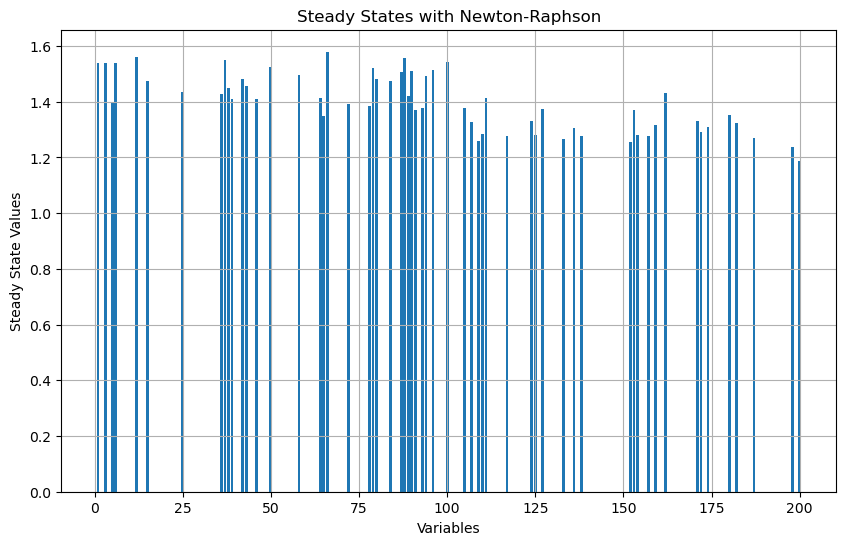

In [51]:
from scipy.optimize import root
def glv_system2(x, r, A, m, m_ij):
    dxdt = x * (r + np.dot(A, x)) - m * x + np.dot(m_ij, x)
    return dxdt

def find_steady_state(glv_system2, x0, r, A, m, m_ij):
    """
    Finds the steady state of the generalized Lotka-Volterra (GLV) system using the Newton-Raphson method.

    Parameters:
    glv_system (function): The GLV system function.
    x0 (array-like): Initial guess for the state variables.
    r (array-like): Growth rates.
    A (array-like): Interaction matrix.
    m (array-like): Mortality rates.
    m_ij (array-like): Additional interaction parameters.

    Returns:
    np.ndarray: Steady state values of the state variables.
    """
    sol = root(glv_system2, x0, args=(r, A, m, m_ij), method='hybr')
    return sol.x

#Example of usage
# Example usage
L = 2
S = 100
C = 0.7
sigma = 0.02
Pc = 0
Pm = 1
Pe = 0
s = 1

m = 0
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)

# Get Nhatstar for these parameters
Nhatstar = find_feasible_equilibrium(A, r, m, m_ij)


Nhatstar = replace_negative_values_with_ones(Nhatstar)

# Initial conditions
x0 = Nhatstar

steady_state = find_steady_state(glv_system2, x0, r, A, m, m_ij)
print("Steady state values:")
for i, value in enumerate(steady_state, start=1):
    print(f"Variable {i}: {value:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(steady_state) + 1), steady_state)
plt.xlabel('Variables')
plt.ylabel('Steady State Values')
plt.title('Steady States with Newton-Raphson')
plt.grid(True)
plt.show()

## Function to set the Jacobian matrix J

$$ J=D*A+G$$

__D__ is a diagonal matrix with the approximation of population equilibria of all the species in the systems  $D= \hat{N_i}^*$ 

__A__ is the interaction matrix, effects of species _j_ on species _i_

__G__ is the dispersal matrix with entries describing the dispersal of species between local communities

In [52]:
def Compute_J(A, Nstar, m_ij):
    """
    This is Stone version of the J metacommunity matrix
    """
    #Assemble G matrix (dispersal)
    G = np.zeros_like(A)
    np.fill_diagonal(G, -1 / Nstar * (m_ij @ Nstar))
    G += m_ij
    
    #Assemble D matrix containing the N_i* for all the species in the system
    D = np.diag(Nstar)
    
    #Assemble Stability Matrix like Roberts and Stone
    S=D@A
    #Assemble Jacobian
    J= S +G
    
    return J

#Example of usage
#parameters
L=3
S=25
C=0.2
sigma= 0.02
Pc=0.5
Pm=0.25
Pe=0.25
s= 1

m=3
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)

Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
Nstar = simulate_glv_system(glv_system, Nhatstar, r, A, m, m_ij, tmax=10)

J=Compute_J(A,Nstar,m_ij)
plot_matrix(J,title="Metacommunity Matrix", use_meta=True)

## Function calculate the max(Re($\lambda$))

In [53]:
def max_real_eigenvalue(matrix):
    """
    Calculate the maximum real part of the eigenvalues of a matrix.
    
    Parameters:
    matrix (np.ndarray): The input matrix.
    
    Returns:
    float: The maximum real part of the eigenvalues.
    """
    eigenvalues = np.linalg.eigvals(matrix)
    max_real_part = np.max(np.real(eigenvalues))
    return max_real_part


max_real=max_real_eigenvalue(J)
max_real

-0.9116510275273425

### Plot eigenvalues distribution

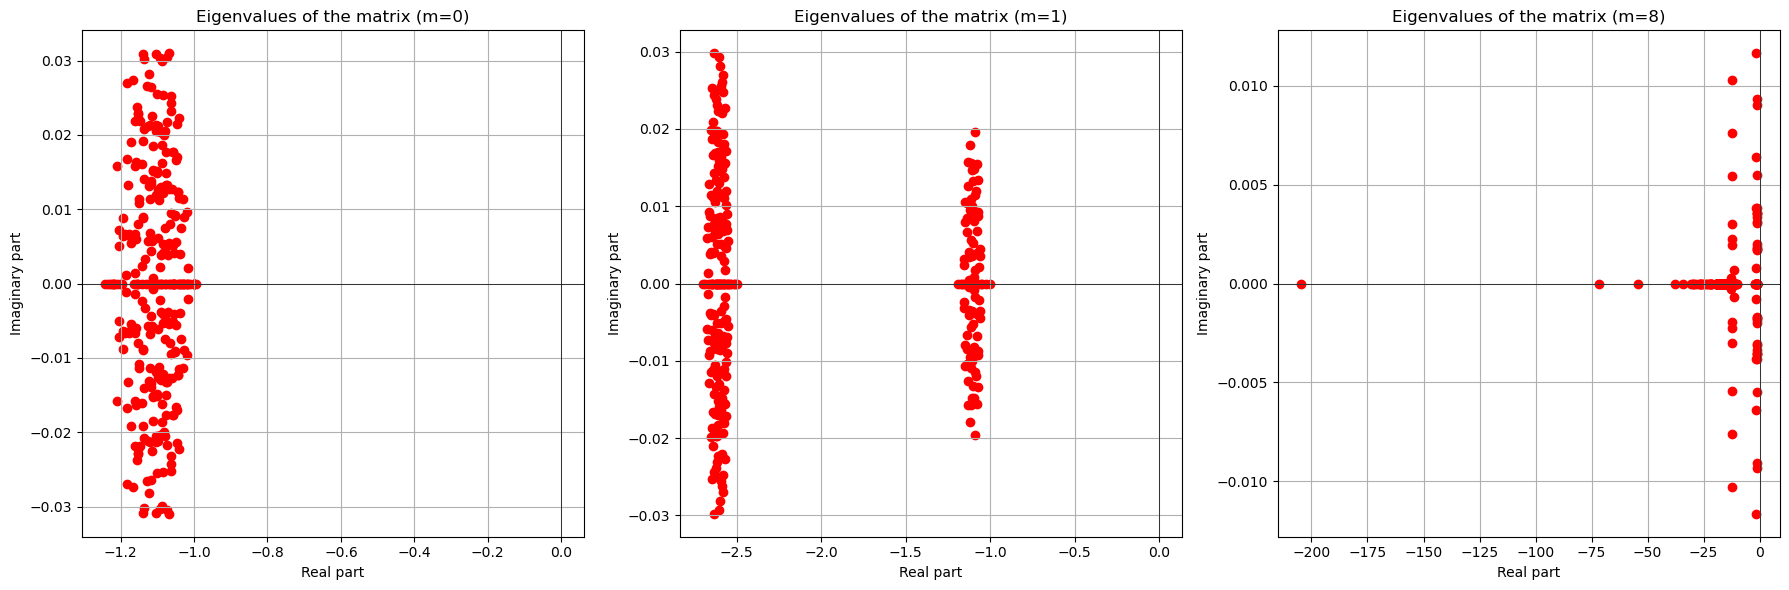

In [54]:
# exploring the plots
# Parameters
L = 3
S = 100
C = 0.2
sigma = 0.02
Pc = 0
Pm = 0.6
Pe = 0.4
s = 2
matrix_para = {'S': S, 'C': C, 'sigma': sigma, 'Pm': Pm, 'Pc': Pc, 'Pe': Pe, 's': s}
r = np.ones(S * L)

# Values of m to plot
m_values = [0, 1, 8]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, m in enumerate(m_values):
    A=meta_A(L,S,matrix_para)
    m_ij=get_mij(L,S,m)

    Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)


    if A is None or m_ij is None:
        raise ValueError("A or m_ij is None. Check the implementation of meta_A and migration functions.")
    
    J=Compute_J(A,Nhatstar,m_ij)

    # Compute the eigenvalues
    eigenvalues, _ = np.linalg.eig(J)

    # Plot the eigenvalues
    axs[i].scatter(eigenvalues.real, eigenvalues.imag, color='red')
    axs[i].set_title(f'Eigenvalues of the matrix (m={m})')
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].grid(True)
    axs[i].axhline(0, color='black', linewidth=0.5)
    axs[i].axvline(0, color='black', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()